# Load data

In [102]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


In [154]:
data = './processed/'
batch_size = 32
image_size=(200,200)
training_set = tf.keras.utils.image_dataset_from_directory(
    data,
    validation_split=0.2,
    subset="training",
    image_size=image_size,
    seed=123,
    batch_size=batch_size,
)

testing_set = tf.keras.utils.image_dataset_from_directory(
    data,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=image_size,
    batch_size=batch_size,
)


Found 16 files belonging to 2 classes.
Using 13 files for training.
Found 16 files belonging to 2 classes.
Using 3 files for validation.


In [119]:
training_set= training_set.unbatch()

In [120]:
training_set

<_UnbatchDataset element_spec=(TensorSpec(shape=(200, 200, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [124]:
class_names = training_set.class_names
print(class_names)

['khalil', 'others']


(13, 200, 200, 3)
[1 0 1 1 0 0 0 0 1 0 0 1 0]


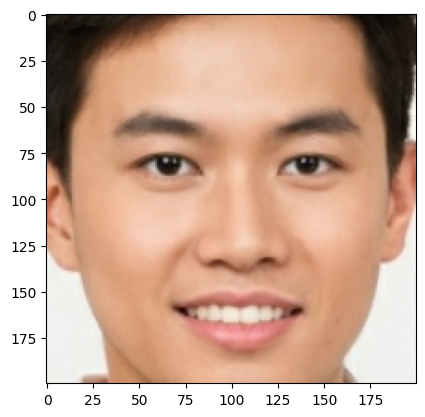

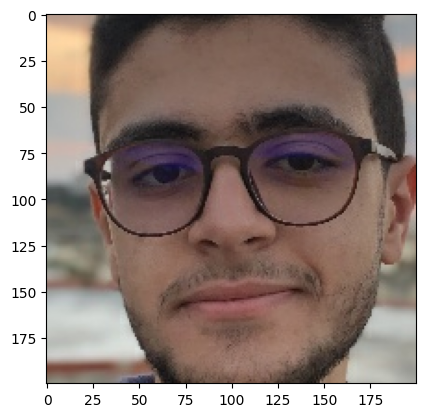

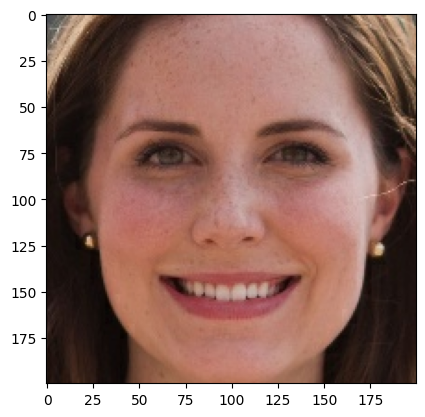

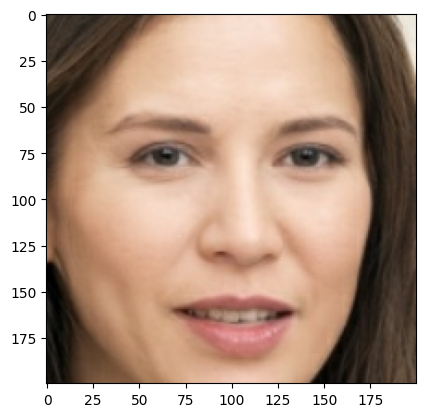

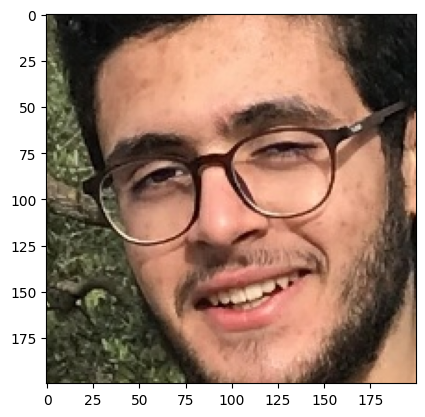

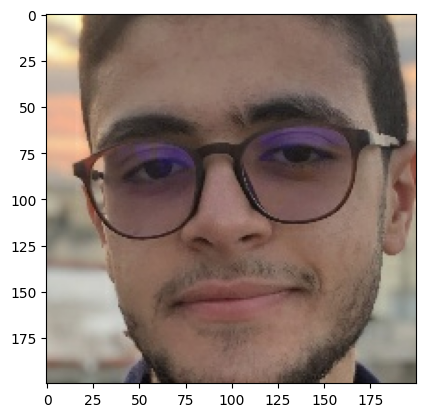

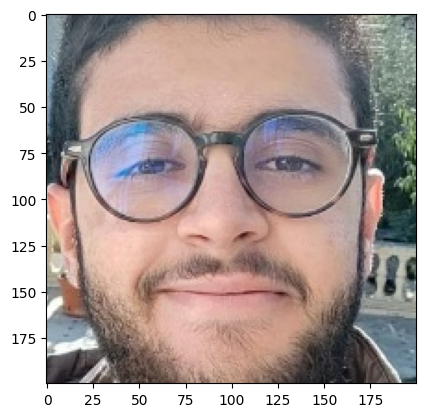

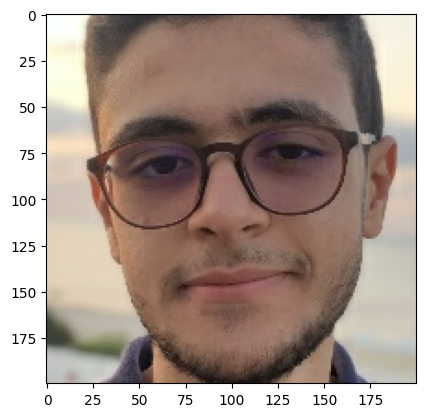

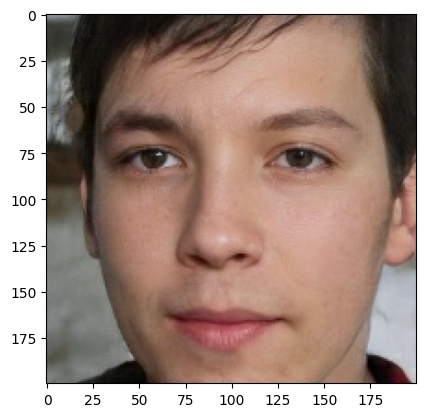

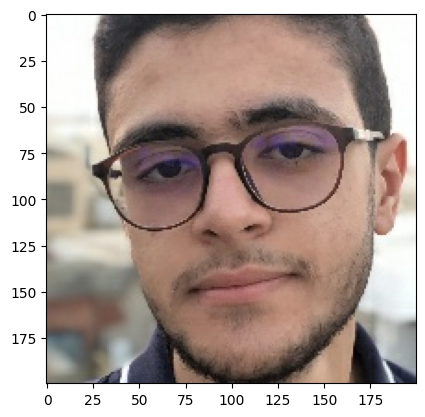

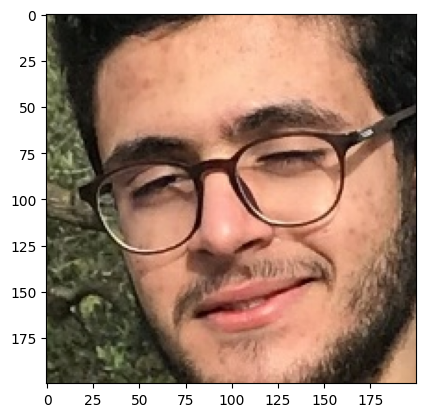

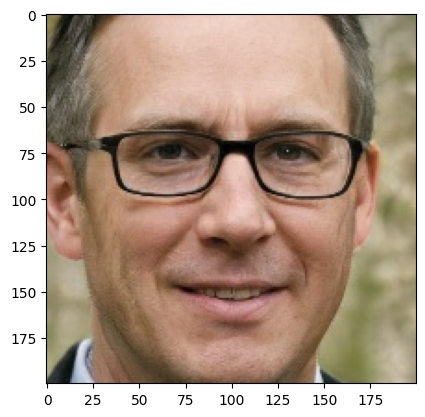

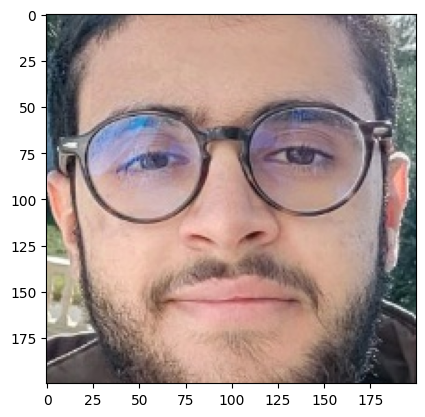

In [128]:
for images, labels in training_set:
    print(images.shape)
    print(labels.numpy())
    for image in images:
        plt.imshow(image.numpy().astype("uint8"))
        plt.show()
    break

In [132]:
training_set = training_set.unbatch()

TypeError: The dataset length is unknown.

Visualize the data

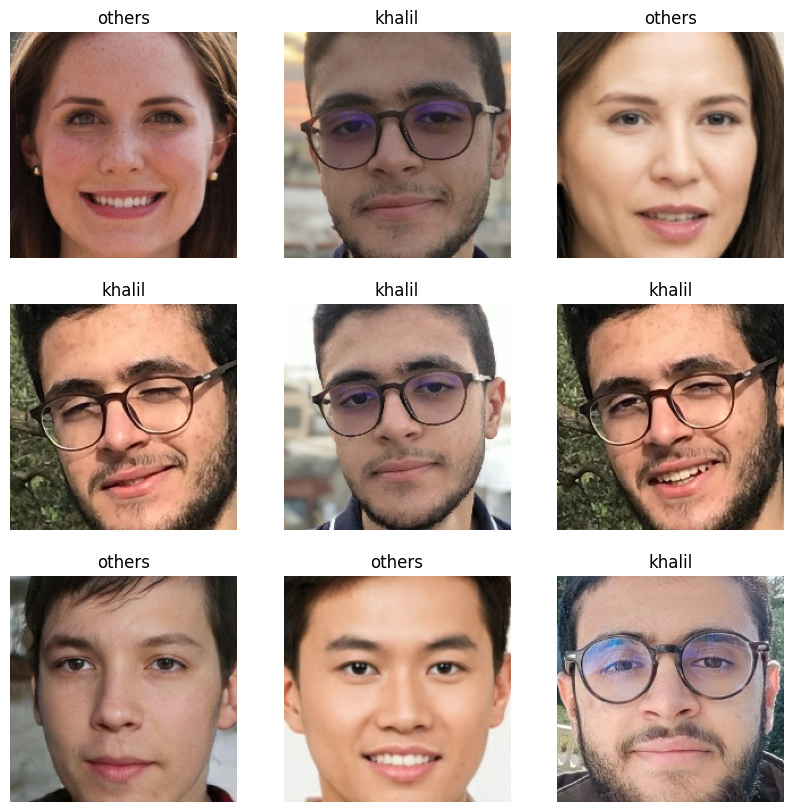

In [105]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in training_set.take(5):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [106]:
for image_batch, labels_batch in training_set:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(13, 200, 200, 3)
(13,)


Standardize the data

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = training_set.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


Data augmentation

In [130]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical", input_shape=(200, 200, 3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.Rescaling(1./255),]
)

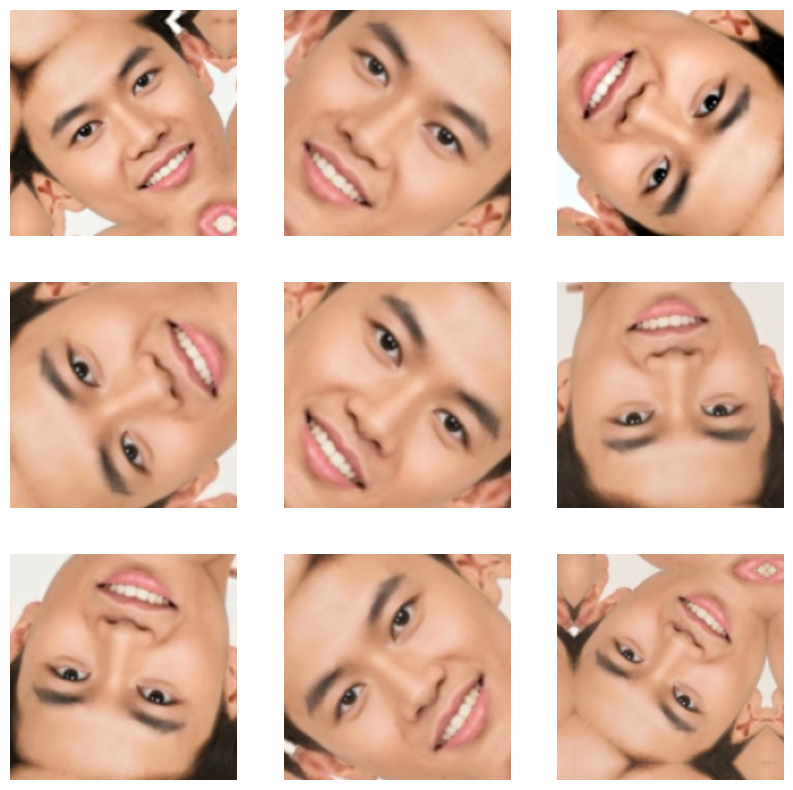

In [108]:
# test the data augmentation layer on a single image
for image, _ in training_set.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0])
        plt.axis("off")

In [ ]:
i=0
for image, _ in training_set.take(1):
    first_image = image[0]
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))

plt.imshow(augmented_image[0])

In [155]:
aug_ds=training_set.map(lambda x, y: (data_augmentation(x), y))

In [157]:
aug_ds=aug_ds.unbatch()

In [110]:
for image_batch, labels_batch in aug_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(13, 200, 200, 3)
(13,)


In [169]:
aug_ds2=testing_set.map(lambda x, y: (data_augmentation(x), y))

In [170]:
aug_ds2=aug_ds2.unbatch()

In [173]:
for i in aug_ds2:
    print(i[0].shape)

(200, 200, 3)
(200, 200, 3)
(200, 200, 3)


In [160]:
aug_ds3=aug_ds.concatenate(aug_ds2)

In [165]:
for i in aug_ds3:
    print(len(i))

2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


In [112]:
# concat aug_ds and aug_ds2
train_ds = tf.data.Dataset.concatenate(aug_ds, aug_ds2)

In [116]:
# shuffle and batch
train_ds = train_ds.shuffle(1000).batch(32)
train_ds = train_ds.prefetch(buffer_size=32)


In [ ]:
# visualize the augmented images
for image_batch, labels_batch in aug_ds:
  print(image_batch.shape)
  for img in image_batch:
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    

In [ ]:
# expand training set with augmented images
training_set = training_set.concatenate(aug_ds)

In [ ]:
# show the new training set size
for image_batch, labels_batch in training_set:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

In [ ]:
# show all images in the training set
for image_batch, labels_batch in training_set:
    print(image_batch.shape)
    for img in image_batch:
        plt.imshow(img)
        plt.axis("off")
        plt.show()

###########################

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')


In [ ]:
train_data= train_datagen.flow_from_directory(
    directory="./processed/",
    batch_size=32,
    class_mode="categorical",
    save_to_dir="./output/",
)

In [ ]:
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_datagen,
    output_types=(tf.float32, tf.float32),
    output_shapes=([32, 200, 200, 3], [32, ])
)


In [ ]:
tf.data.experimental.cardinality(train_dataset)

In [ ]:
train_dataset = train_dataset.apply(
    tf.data.experimental.assert_cardinality(16))


In [ ]:
len(train_dataset)